In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from random import choice
from gurobipy import Model, GRB, quicksum
import time

# Problem 1 - Passenger Assignment

Implement a passenger assignment algorithm of your choice. Note that all input and output data is in csv format and can be viewed in any text editor. The columns of the csv files are described below.

In [182]:
folders = ["Input/Data set toy/", "Input/Data set mandl/"]

For all of the problems, I will utilize the `networX` package. From the set of stops and edges, we need to create a graph. Each edge has length. Each bus stop has a name and position.

At first, I will work with a Toy dataset and then proceed to the larger dataset. 

In [183]:
def generate_G(nodes, edges, directed=True):

    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    coor = nodes.columns[3:5]
    
    for i, node in nodes.iterrows():
        G.add_node(node['stop-id'], pos=(node[coor[0]], node[coor[1]]))

    for i, edge in edges.iterrows():
        G.add_edge(edge['left-stop-id'], edge['right-stop-id'])
        
    return G

def plot_map(G, nodes, names=True):
    fig, ax = plt.subplots(figsize=(12,6))

    if names:
        selected = nodes.columns[1:3]
        mapping = dict(zip(nodes[selected[0]], nodes[selected[1]]))
        G = nx.relabel_nodes(G, mapping)

    pos=nx.get_node_attributes(G,'pos')  
    nx.draw_networkx(G, pos=pos)
    plt.show()

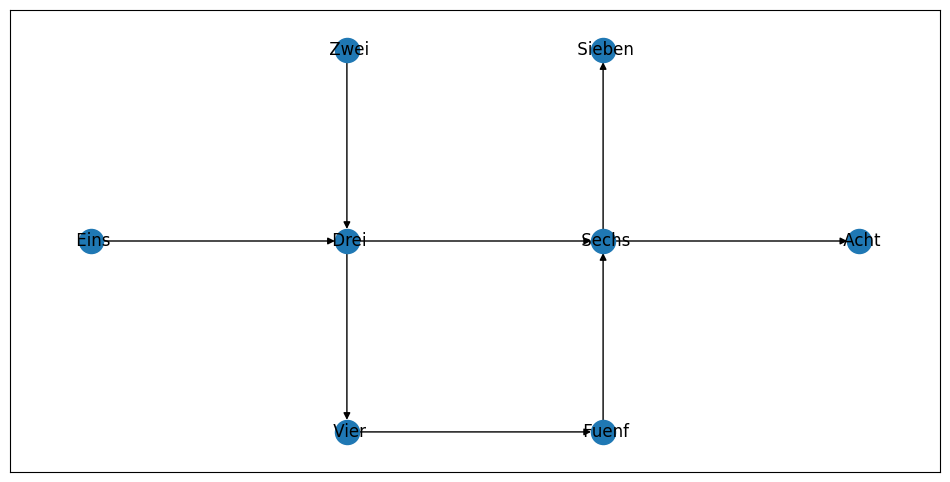

In [184]:
files = ["Edge.giv", "Stop.giv", "OD.giv", "Load.giv"]
edges = pd.read_csv(folders[0]+files[0], sep=";")
nodes = pd.read_csv(folders[0]+files[1], sep=";")

G = generate_G(nodes, edges)
plot_map(G, nodes)

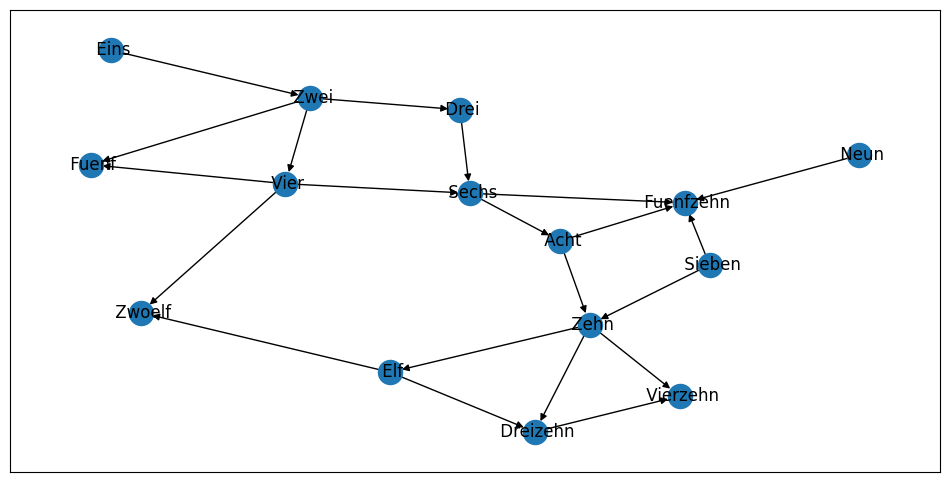

In [185]:
edges = pd.read_csv(folders[1]+files[0], sep=";")
nodes = pd.read_csv(folders[1]+files[1], sep=";")


G = generate_G(nodes, edges)
plot_map(G.copy(), nodes)

Now, we have a `OD.giv` dataset that has set of all OD pairs that we need to assign to the paths

For each of the pairs, we need to find set of reasonable paths: this can be done with `nx.all_simple_paths()` function, which returns paths with non-repeated nodes. Then we filter out those paths that are dominated by other paths (in terms of minimum/maximum time and length)

In [186]:
weights_options = edges.columns[3:6]

In [187]:
def leave_non_dominated_path(values):
    dominated = []
    for i in range(len(values)):
        for j in range(len(values)):
            if i!= j:
                if (values[i] <= values[j]).all() and (values[i] <= values[j]).any():
                    dominated.append(j)
    return dominated

I will assume that the Graph is not directed in this part, since otherwise otherwise some passengers won't have a path.

In [188]:
def generate_reasonable_paths(G, OD_pairs, cutoff=None, dominance=False):
    paths_dict = {
        'source': [],
        'target': [],
        'path': [],
        weights_options[0]:[],
        weights_options[1]:[],
        weights_options[2]:[]
    }
     
    for pair in range(OD_pairs.shape[0]):
        source = OD_pairs[pair, 0]
        target  = OD_pairs[pair, 1]
        paths = [p for p in nx.all_simple_paths(G, source=source, target=target, cutoff=cutoff)]
 
        values = []
        for path in paths:

            temp = np.zeros(3)

            for i in range(len(path) - 1):
                source = path[i]
                target  = path[i+1]
                temp+= edges[((edges['left-stop-id'] == source) & (edges['right-stop-id'] == target)) | 
                                ((edges['left-stop-id'] == target) & (edges['right-stop-id'] == source))][weights_options].values[0]
            values.append(temp)

        if dominance:
            dominated = leave_non_dominated_path(values)
        else:
            dominated = []
        for i, j in enumerate(paths):
            if dominated == [] or i not in dominated:  # if path is not dominated by other paths, add it to the result
                paths_dict['source'].append(j[0])
                paths_dict['target'].append(j[-1])
                paths_dict['path'].append(j)
                paths_dict[weights_options[0]].append(values[i][0])
                paths_dict[weights_options[1]].append(values[i][1])
                paths_dict[weights_options[2]].append(values[i][2])
                
    return pd.DataFrame(paths_dict)

To calculate the weight for the paths I will use Kirchhoff model. I will asign the weights for each path using the following formulas:
$$w_i^{uv} = p(i)C_uv$$
where, $$p(i) = \frac{(V_i^{uv})^\beta}{\sum_{j=1}^k(V_i^{uv})^\beta}$$

For now, $\beta=2$

In [189]:
def assign_passengers(G, OD, cutoff= None, dominance=False):

    paths = generate_reasonable_paths(G, OD.values, cutoff=cutoff, dominance=dominance)

    OD_pairs = OD.values

    for j in range(3):
        passengers = []
        for pair in range(OD_pairs.shape[0]):
            source = OD_pairs[pair, 0]
            target  = OD_pairs[pair, 1]

            curent_paths = paths[(paths['source'] == source) & (paths['target'] == target)][weights_options[j]].values
            
            if len(curent_paths):
                V_sum = np.sum(curent_paths**2, axis = 0)
                C_uv = OD[(OD['left-stop-id'] == source) & (OD['right-stop-id'] == target)]['customers'].values
                p = []
                for i in range(curent_paths.shape[0]):
                    if C_uv == 0:
                        p.append(0)
                    else:
                        p.append(np.floor(curent_paths[i]**2/V_sum * C_uv))
                p[np.argmin(p)] += C_uv - np.sum(p, axis=0)
                passengers.extend(p)
            passengers = np.concatenate([item if isinstance(item, np.ndarray) else np.array([item]) for item in passengers]).tolist()
        paths['passengers_'+weights_options[j]] = passengers
    return paths


We assigned passengers to different paths by defining paths weight using different parameters: total length, min travel time, max travel time

In [190]:
def calculate_loads(nodes, edges, OD, n, A, directed=True, dominance=True):
    
    G = generate_G(nodes, edges, directed=directed)

    edge_load = pd.DataFrame()
    edge_load['edge-id'] = edges['edge-id']

    passengers_assignement = assign_passengers(G, OD, dominance=dominance)

    loads = np.zeros(len(edges))

    for i, e in enumerate(G.edges()):

        load = 0
        
        for p in passengers_assignement[['path', 'passengers_'+weights_options[n]]].values:

            path = set(zip(p[0][:-1], p[0][1:]))
            if e in path:
                load+= p[1]

        loads[i] = load

    loads = np.array(loads)
    edge_load['load'] =  loads
    edge_load['lower-frequency'] =  np.ceil(loads/A)
    edge_load['upper-frequency'] =  np.ones(len(edges))*20

    return passengers_assignement, edge_load

## Generate output files for datasets and measure runtime

In [191]:
edges = pd.read_csv(folders[0]+files[0], sep=";")
nodes = pd.read_csv(folders[0]+files[1], sep=";")
OD = pd.read_csv(folders[0]+files[2], sep=";")

A = 70

start_time = time.time()
passengers_paths_, found_loads_toy = calculate_loads(nodes, edges, OD, 0, A, dominance=True, directed=False)
print("--- %s seconds ---" % (time.time() - start_time))

found_loads_toy.to_csv("Output/Problem 1/toy_dataset/Load.giv", sep=";", index=False)

found_loads_toy

--- 0.16239690780639648 seconds ---


,edge-id,load,lower-frequency,upper-frequency
0,1,200.0,3.0,20.0
1,2,251.0,4.0,20.0
2,3,132.0,2.0,20.0
3,4,603.0,9.0,20.0
4,5,168.0,3.0,20.0
5,6,608.0,9.0,20.0
6,7,181.0,3.0,20.0
7,8,160.0,3.0,20.0


In [192]:
edges = pd.read_csv(folders[1] + files[0], sep=";")
nodes = pd.read_csv(folders[1] + files[1], sep=";")
OD = pd.read_csv(folders[1] + files[2], sep=";")

A = 450

start_time = time.time()
passengers_paths_, found_loads_mandl = calculate_loads(nodes, edges, OD, 0, A, dominance=True, directed=False)
print("--- %s seconds ---" % (time.time() - start_time))

found_loads_mandl.to_csv("Output/Problem 1/mandl/Load.giv", sep=";", index=False)
found_loads_mandl

--- 15.800204038619995 seconds ---


,edge-id,load,lower-frequency,upper-frequency
0,1,1320.0,3.0,20.0
1,2,1455.0,4.0,20.0
2,3,265.0,1.0,20.0
3,4,160.0,1.0,20.0
4,5,1550.0,4.0,20.0
5,6,320.0,1.0,20.0
6,7,805.0,2.0,20.0
7,8,125.0,1.0,20.0
8,9,2315.0,6.0,20.0
9,10,560.0,2.0,20.0


## Test quality 

In [193]:
def quality(loads, edges):
    return np.sum(loads['load']*edges[weights_options[0]]), np.sum(loads['load']*edges[weights_options[1]]), np.sum(loads['load']*edges[weights_options[2]])

In [194]:
Load = pd.read_csv(folders[0]+files[3], sep=";")
edges = pd.read_csv(folders[0] + files[0], sep=";")

sample, mysolution = quality(Load, edges), quality(found_loads_toy, edges)
quality_solutions = pd.DataFrame(np.array([sample, mysolution]), columns = weights_options)
quality_solutions['solution'] = ['Sample solution', "My solution"] 

quality_solutions[['solution'] + list(weights_options)]

,solution,length,lower-bound,upper-bound
0,Sample solution,2312.0,6880.0,10950.0
1,My solution,2269.4,6718.0,13017.0


In [195]:
Load = pd.read_csv(folders[1]+files[3], sep=";")
edges = pd.read_csv(folders[1] + files[0], sep=";")

sample, mysolution = quality(Load, edges), quality(found_loads_mandl, edges)
quality_solutions = pd.DataFrame(np.array([sample, mysolution]), columns = weights_options)
quality_solutions['solution'] = ['Sample solution', "My solution"] 

quality_solutions[['solution'] + list(weights_options)]

,solution,length,lower-bound,upper-bound
0,Sample solution,53162.45,79120.0,79120.0
1,My solution,52340.05,77895.0,77895.0


# Problem 2 - Line Planning

In [196]:
def check_feasibility(line_concept, load):
    freq = []
    for i in range(0, len(load)):
        freq.append(sum(line_concept[line_concept['edge-id']== i+1]['frequency']))

    freq = np.array(freq)
    return sum(freq<=20) == len(freq)

def check_quality_of_lines(solution, line_concept, pool_cost, load, chosen_lines=None):
    if chosen_lines is None:
        chosen_lines = np.unique(line_concept[line_concept['frequency']>0]['line-id'])
    cost = 0
    for f in pool_cost.values:
        if f[0] in chosen_lines:
            cost+= f[2]
    return solution, cost, sum(line_concept['frequency']), check_feasibility(line_concept, load), list(chosen_lines), len(chosen_lines)

In [197]:
def generate_line_concept(pool_cost, pool, load):

    pool['frequency'] = 0
    chosen_lines = []

    while True:
        if max(load['lower-frequency'].values) == 0:
            break
        
        max_edge = load.values[np.argmax(load['lower-frequency'].values)][0]
        candidates = pool[pool['edge-id'] == max_edge]['line-id'].values

        g = []
        f_min = []

        for c in candidates:

            line_cost =  pool_cost[pool_cost['line-id'] == c]['cost'].values

            line_edges = [
                load[load['edge-id'] == e]['lower-frequency'].values[0] 
                for e in pool[pool['line-id'] == c]['edge-id'] 
                if load[load['edge-id'] == e]['lower-frequency'].values[0] > 0
            ]
            
            if len(line_edges) == 0:
                break

            n = len(line_edges)
            f_min.append(min(line_edges))
            g.append(line_cost/n)

        choose = np.argmin(g)
        chosen_lines.append(candidates[choose])
        pool.loc[pool['line-id'] == candidates[choose], 'frequency'] += f_min[choose]


        for e in pool[pool['line-id'] == candidates[choose]]['edge-id']:

            val = load[load['edge-id'] == e]['lower-frequency'].values
            load.loc[load['edge-id'] == e, 'lower-frequency'] = max(val - f_min[choose], 0)
        
    return pool

In [198]:
files = ["Load.giv", "Pool-Cost.giv", "Pool.giv", "Line-Concept.lin"]

load = pd.read_csv(folders[0]+files[0], sep=";")
pool_cost = pd.read_csv(folders[0]+files[1], sep=";")
pool = pd.read_csv(folders[0]+files[2], sep=";")

start_time = time.time()
line_concept_toy = generate_line_concept(pool_cost, pool.copy(), load.copy())
print("--- %s seconds ---" % (time.time() - start_time))

line_concept_toy.to_csv("Output/Problem 2/toy_dataset/Line-Concept.lin", index=False, sep=";")

line_concept_toy

--- 0.021276235580444336 seconds ---


,line-id,edge-order,edge-id,frequency
0,1,1,1,0
1,1,2,6,0
2,1,3,7,0
3,2,1,2,3
4,2,2,6,3
5,2,3,8,3
6,3,1,5,2
7,4,1,6,4
8,4,2,5,4
9,5,1,2,1


In [199]:
line_concept_sample = pd.read_csv(folders[0]+files[3], sep=";")
q_sample = check_quality_of_lines("Sample solution", line_concept_sample, pool_cost, load)
q_toy = check_quality_of_lines("My solution", line_concept_toy, pool_cost, load)
# Convert to a DataFrame
df = pd.DataFrame([q_sample, q_toy], columns=["Solution", "Cost", "Total frequency", "Feasible",  "Lines", "Number of lines"])
df

,Solution,Cost,Total frequency,Feasible,Lines,Number of lines
0,Sample solution,18.4,39,True,"[2, 3, 4, 6, 8]",5
1,My solution,21.4,39,True,"[2, 3, 4, 5, 6, 8]",6


In [200]:
load = pd.read_csv(folders[1]+files[0], sep=";")
pool_cost = pd.read_csv(folders[1]+files[1], sep=";")
pool = pd.read_csv(folders[1]+files[2], sep=";")

start_time = time.time()
line_concept_mandl = generate_line_concept(pool_cost, pool.copy(), load.copy())
print("--- %s seconds ---" % (time.time() - start_time))

line_concept_mandl.to_csv("Output/Problem 2/mandl/Line-Concept.lin", index=False, sep=";")

line_concept_mandl 

--- 0.14872193336486816 seconds ---


,line-id,edge-order,edge-id,frequency
0,1,1,21,1
1,1,2,20,1
2,1,3,16,1
3,1,4,13,1
4,1,5,9,1
...,...,...,...,...
113,24,2,13,0
114,25,1,17,1
115,26,1,16,0
116,27,1,13,0


In [201]:
line_concept_sample = pd.read_csv(folders[1]+files[3], sep=";")
q_sample = check_quality_of_lines("Sample solution", line_concept_sample, pool_cost, load)
q_mandl  = check_quality_of_lines("My solution", line_concept_mandl , pool_cost, load)

# Convert to a DataFrame
df = pd.DataFrame([q_sample, q_mandl], columns=["Solution", "Cost", "Total frequency", "Feasible",  "Lines", "Number of lines"])
df

,Solution,Cost,Total frequency,Feasible,Lines,Number of lines
0,Sample solution,459.6375,50,True,"[3, 5, 7, 8, 9, 10, 14, 15, 22]",9
1,My solution,560.3890,61,True,"[1, 3, 5, 8, 9, 12, 13, 15, 16, 22, 25]",11


# Problem 3 - Passenger Routing in Event-Activity Networks

We need to create an event-activity graph, where events are nodes and activities are edges.

In [202]:
def generate_passenger_weights(events, activities, OD):

    G = nx.DiGraph()
    
    for i, event in events.iterrows():
        G.add_node(event['event_id'])
        
    for i, activity in activities.iterrows():
        G.add_edge(activity['from_event'], activity['to_event'], weight=activity['lower_bound'])    

    passenger_weights = {edge: 0 for edge in G.edges()}
    
    events['passengers']=0

    # Route passengers based on the OD matrix
    for _, row in OD.iterrows():

        origin = row['left-stop-id']
        destination = row['right-stop-id']
        customers = row['customers']
        
        # Find the closest departure events from the origin and arrival events at the destination
        origin_events = events[(events['stop-id'] == origin) & (events['type'] == 'departure')]['event_id'].values
        destination_events = events[(events['stop-id'] == destination) & (events['type'] == 'arrival')]['event_id'].values
        # Route passengers between each combination of origin and destination events

        paths = []
        weights = []

        for o_event in origin_events:
            for d_event in destination_events:
                try:
                    # Use Dijkstra's algorithm to find the shortest path based on 'weight' (lower_bound)
                    path = nx.dijkstra_path(G, source=o_event, target=d_event, weight='weight')
                    paths.append(path)
                    weights.append(nx.path_weight(G, path, weight='weight'))
                    
                except nx.NetworkXNoPath:
                    # If no path is found, skip to the next pair
                    continue

        chosen_path = paths[np.argmin(weights)]


        for i in range(len(chosen_path) - 1):
            edge = (chosen_path[i], chosen_path[i + 1])
            passenger_weights[edge] += customers

    temp = pd.DataFrame(
        [(from_event, to_event, weight) for (from_event, to_event), weight in passenger_weights.items()],
        columns=['from_event', 'to_event', 'passenger_weight']
    )

    activity_id = []
    upper_bound = []
    lower_bound = []
    type = []

    for u, v, w in temp.values:
        matching_events = activities[(activities['from_event'] == u) & (activities['to_event'] == v)][["activity_index", "lower_bound","upper_bound", "type"]].values[0]
        events.loc[(events['event_id'] == v) & (events['type'] == "arrival"), 'passengers'] += w
        activity_id.append(matching_events[0]) 
        lower_bound.append(matching_events[1]) 
        upper_bound.append(matching_events[2]) 
        type.append(matching_events[3]) 
    
    activity_new = pd.DataFrame()
    activity_new["activity_index"] = activity_id
    activity_new["type"] = type
    activity_new['from_event'] = temp['from_event']
    activity_new['to_event'] = temp['to_event']

    activity_new["lower_bound"] = lower_bound
    activity_new["upper_bound"] = upper_bound

    activity_new['passengers'] = temp['passenger_weight']
    activity_new = activity_new.sort_values(by=['activity_index'])
    
    return activity_new, events

In [203]:
files = ["Activities-periodic.giv", "Events-periodic.giv", "OD.giv"]

activities = pd.read_csv(folders[0]+files[0], sep=";")
events = pd.read_csv(folders[0]+files[1], sep=";")
OD = pd.read_csv(folders[0]+files[2], sep=";")

events['type'] = events['type'].str.replace('"', '').str.strip()
activities['type'] = activities['type'].str.replace('"', '').str.strip()

start_time = time.time()
new_activities, new_events = generate_passenger_weights(events.copy(), activities.copy(), OD)
print("--- %s seconds ---" % (time.time() - start_time))

new_activities.to_csv("Output/Problem 3/toy_dataset/Activities-periodic.giv", sep=";", index="False")
new_events.to_csv("Output/Problem 3/toy_dataset/Events-periodic.giv", sep=";", index="False")

--- 0.9902169704437256 seconds ---


In [204]:
d1 = "My solution", sum(new_activities['passengers']*new_activities['lower_bound']), sum(new_activities['passengers']*new_activities['upper_bound'])
d2 = "Sample solution", sum(activities['passengers']*activities['lower_bound']), sum(activities['passengers']*activities['upper_bound'])

df = pd.DataFrame([d2, d1], columns=["Solution", "Min total travel time", "Max total travel time"])
df

,Solution,Min total travel time,Max total travel time
0,Sample solution,18204,54556
1,My solution,16044,70156


In [205]:
def quality_of_activities(activities, A):
    # Create a boolean mask for rows where type is 'wait' or 'drive' and passengers >= A
    idx = (activities["type"].isin(["wait", "drive"])) & (activities["passengers"] >= A)
    # Calculate the sum of passengers * lower_bound for rows that match the condition
    result_1 = (activities[idx]["passengers"] * activities[idx]["lower_bound"]).sum()
    result_2 = (activities[idx]["passengers"] * activities[idx]["upper_bound"]).sum()

    return result_1, result_2

In [206]:
d1 = quality_of_activities(new_activities, 70)
d2 = quality_of_activities(activities, 70)

df = pd.DataFrame([d2, d1], columns=["Min total travel time", "Max total travel time"])
df['Solution'] = ["Sample solution", "My solution"]
df[['Solution',"Min total travel time", "Max total travel time"]]

,Solution,Min total travel time,Max total travel time
0,Sample solution,14935,26920
1,My solution,13358,23472


In [207]:
activities = pd.read_csv(folders[1]+files[0], sep=";")
events = pd.read_csv(folders[1]+files[1], sep=";")
OD = pd.read_csv(folders[1]+files[2], sep=";")

events['type'] = events['type'].str.replace('"', '').str.strip()
activities['type'] = activities['type'].str.replace('"', '').str.strip()

start_time = time.time()
new_activities, new_events = generate_passenger_weights(events.copy(), activities.copy(), OD)
print("--- %s seconds ---" % (time.time() - start_time))

new_activities.to_csv("Output/Problem 3/mandl/Activities-periodic.giv", sep=";", index="False")
new_events.to_csv("Output/Problem 3/mandl/Events-periodic.giv", sep=";", index="False")

--- 1.9421849250793457 seconds ---


In [208]:
d1 = "My solution", sum(new_activities['passengers']*new_activities['lower_bound']), sum(new_activities['passengers']*new_activities['upper_bound'])
d2 = "Sample solution", sum(activities['passengers']*activities['lower_bound']), sum(activities['passengers']*activities['upper_bound'])

df = pd.DataFrame([d2, d1], columns=["Solution", "Min total travel time", "Max total travel time"])
df

,Solution,Min total travel time,Max total travel time
0,Sample solution,181200,336120
1,My solution,176630,359070


In [209]:
d1 = quality_of_activities(new_activities, 70)
d2 = quality_of_activities(activities, 70)

df = pd.DataFrame([d2, d1], columns=["Min total travel time", "Max total travel time"])
df['Solution'] = ["Sample solution", "My solution"]
df[['Solution',"Min total travel time", "Max total travel time"]]

,Solution,Min total travel time,Max total travel time
0,Sample solution,170455,197025
1,My solution,166920,191640


# Problem 4 - Generating Event-Activity Networks

Given line concept, we want to generate events and activiies in the network

The full function can be summorized as follows

In [210]:
def generate_EAN(line_concept, OD, edges):

    valid_lines = line_concept[line_concept["frequency"]>0]
    lines, lengths = valid_lines['line-id'].value_counts().reset_index().values.T
    freq = [valid_lines[valid_lines['line-id'] == l]['frequency'].values[0] for l in lines]

    new_events = []
    for l in lines:
        line_info = valid_lines[valid_lines['line-id'] == l]
        edge_info = line_info["edge-id"].values
        freq_line = line_info['frequency'].values[0]
        for f in range(1, freq_line + 1):
            for j, e in enumerate(edge_info):
                e_info = edges[edges["edge-id"] == e]
                new_events.append(["departure", e_info['right-stop-id'].values[0], l, 0, ">", f])
                new_events.append(["arrival", e_info['left-stop-id'].values[0], l, 0, ">",  f])
        for f in range(1, freq_line + 1):
            for j, e in enumerate(edge_info[::-1]):
                e_info = edges[edges["edge-id"] == e]
                new_events.append(["departure", e_info['left-stop-id'].values[0],  l, 0, "<", f])
                new_events.append(["arrival", e_info['right-stop-id'].values[0], l, 0, "<",  f])
                
    df = pd.DataFrame(new_events, columns=["type","stop-id","line-id","passengers","line-direction", "line-freq-repetition"], )
    df['event_id']=np.arange(1, len(new_events)+1)
    new_order = ["event_id"] + [col for col in df.columns if col != "event_id"]
    new_events = df[new_order]


    activities = []
    for k in range(len(lines)):
        for d in [">", "<"]:
            for f in range(1, freq[k]+1):
                target_events = new_events.loc[(new_events['line-id'] == lines[k]) & (new_events['line-direction'] == d)&(new_events['line-freq-repetition']==f)].values
                for j, e in enumerate(target_events):
                    if e[1] == "departure":
                        if f>1:
                            activities.append(["sync", target_events[j][0] - int(lengths[k])*2, target_events[j][0], np.floor(60/freq[k]), np.ceil(60/freq[k]),0])
                        e_info = edges.loc[
        ((edges["right-stop-id"] == target_events[j+1][2]) & (edges["left-stop-id"] == target_events[j][2])) |
        ((edges["left-stop-id"] == target_events[j+1][2]) & (edges["right-stop-id"] == target_events[j][2]))
    ]
                        if j+1<len(target_events):
                            activities.append(["drive", target_events[j][0], target_events[j+1][0], int(e_info['lower-bound'].values[0]), int(e_info['upper-bound'].values[0]), 0])
                    if e[1] == "arrival":
                        if j+1<len(target_events):
                            activities.append(["wait", target_events[j][0], target_events[j+1][0], 1,3,0])

                            
    arr = new_events.loc[(new_events['type']=="arrival")].values
    dept = new_events.loc[(new_events['type']=="departure")].values

    for a in arr:
        for d in dept:
            if a[2]==d[2] and a[3]!=d[3]:
                activities.append(["change", a[0], d[0], 3, 62, 0])
                
    df = pd.DataFrame(activities, columns=["type","from_event","to_event","lower_bound","upper_bound","passengers"] )
    df['activity_index']=np.arange(1, len(activities)+1)
    new_order = ["activity_index"] + [col for col in df.columns if col != "activity_index"]
    new_activities = df[new_order]
    new_activities, new_events = generate_passenger_weights(new_events.copy(), new_activities.copy(), OD)

    return new_activities, new_events

In [211]:
OD = pd.read_csv(folders[0]+"OD.giv", sep=";")
edges = pd.read_csv(folders[0]+"Edge.giv", sep=";")
line_concept = pd.read_csv("Output/Problem 2/toy_dataset/Line-Concept.lin", sep=";")

start_time = time.time()
activities_toy, events_toy = generate_EAN(line_concept, OD, edges)
print("--- %s seconds ---" % (time.time() - start_time))

activities_toy.to_csv("Output/Problem 4/toy_dataset/Activities-periodic.giv", sep=";", index="False")
events_toy.to_csv("Output/Problem 4/toy_dataset/Events-periodic.giv", sep=";", index="False")

--- 2.026203155517578 seconds ---


In [212]:
OD = pd.read_csv(folders[1]+"OD.giv", sep=";")
edges = pd.read_csv(folders[1]+"Edge.giv", sep=";")
line_concept = pd.read_csv("Output/Problem 2/mandl/Line-Concept.lin", sep=";")

start_time = time.time()
activities_mandl, events_mandl = generate_EAN(line_concept, OD, edges)
print("--- %s seconds ---" % (time.time() - start_time))

activities_mandl.to_csv("Output/Problem 4/mandl/Activities-periodic.giv", sep=";", index="False")
events_mandl.to_csv("Output/Problem 4/mandl/Events-periodic.giv", sep=";", index="False")

--- 4.695275068283081 seconds ---


# Problem 5 - Timetabling

We don't care much about frequency yet, since we have sinchronization constraints. So, given we found timetable for first repetition of the line. Backward and forward direction of the line can be considered as separate lines.

Lets make some assumptions about activies
- there are no upper-bounds on transfer activities, thus the lower and upper bounds are [d, d+T-1]
- driving and waiting activies are fixed to their lower bounds.

Lets ensure that these is indeed the case for the input files

In [213]:
def evaluate_time_table(time, activities):
    t = dict(time['time'])
    return np.sum([a[2]*((t[a[1]-1] - t[a[0]-1])%60) for a in activities[['from_event', 'to_event', 'passengers']].values])

In [222]:
def generate_time_table(activities, events, T):


    E = events['event_id'].values
    A = [(a[0], a[1]) for a in activities[['from_event', 'to_event']].values]

    c=dict()
    L=dict()

    for a in activities[['from_event', 'to_event', 'passengers', 'lower_bound']].values:
        c[(a[0], a[1])] = a[2]
        L[(a[0], a[1])] = a[3]

    trans = activities[activities['type']=="change"]
    drive_wait_sync = activities.loc[(activities['type']=="drive")|(activities['type']=="wait")|(activities['type']=="sync")]

    model = Model("rPTT1")
    model.setParam('OutputFlag', 0)
    pi = model.addVars(E, vtype=GRB.INTEGER, lb=0, ub=T-1, name="pi")
    z = model.addVars(A, vtype=GRB.INTEGER, lb=0, ub=2, name="z") 

    model.setObjective(
        quicksum(c[(i,j)] * (pi[j] - pi[i] + z[(i,j)] * T) for i, j in zip(activities['from_event'].values, activities['to_event'].values)),
        GRB.MINIMIZE
    )

    model.addConstrs(
        (pi[j] - pi[i] + T * z[(i,j)] == L[(i,j)] for i, j in zip(drive_wait_sync["from_event"].values, drive_wait_sync["to_event"].values)),
        name="EqualityConstraints"
    )

    model.addConstrs(
        (pi[j] - pi[i] + T * z[(i,j)] >= L[(i,j)] for i, j in zip(trans["from_event"].values, trans["to_event"].values)),
        name="InequalityConstraints"
    )

    i_star = np.random.choice(events["event_id"].values)
    model.addConstr(pi[i_star] == 0, name="SingleEqualityConstraint")

    # Solve the model
    model.optimize()

    # Display results
    if model.status == GRB.OPTIMAL:
        pi_solution = [pi[i].x for i in range(1, len(E)+1)]   
        print(f"Optimal solution found {model.ObjVal}")

        return pd.DataFrame({'event_id':events['event_id'], 'time': pi_solution})
    else:
        print("No optimal solution found")
        return None

In [223]:
def evaluate_time_table(time, activities):
    t = dict(time['time'])
    return np.sum([a[2]*((t[a[1]-1] - t[a[0]-1])%60) for a in activities[['from_event', 'to_event', 'passengers']].values])

In [224]:
files = ["Activities-periodic.giv", "Events-periodic.giv"]

activities = pd.read_csv(folders[0]+files[0], sep=";")
events = pd.read_csv(folders[0]+files[1], sep=";")

events['type'] = events['type'].str.replace('"', '').str.strip()
activities['type'] = activities['type'].str.replace('"', '').str.strip()

T = 60

start_time = time.time()
time_table_toy = generate_time_table(activities, events, T)
print("--- %s seconds ---" % (time.time() - start_time))

time_table_toy.to_csv("Output/Problem 5/toy_dataset/Timetable-periodic.tim", sep=";", index="False")
time_table_toy

Optimal solution found 20046.0
--- 0.37073564529418945 seconds ---


,event_id,time
0,1,44.0
1,2,47.0
2,3,48.0
3,4,49.0
4,5,50.0
...,...,...
151,152,19.0
152,153,20.0
153,154,24.0
154,155,25.0


In [225]:
time_table = pd.read_csv(folders[0]+"Timetable-periodic.tim", sep=";")
evaluate_time_table(time_table, activities)

np.int64(20046)

In [226]:
activities = pd.read_csv(folders[1]+files[0], sep=";")
events = pd.read_csv(folders[1]+files[1], sep=";")

events['type'] = events['type'].str.replace('"', '').str.strip()
activities['type'] = activities['type'].str.replace('"', '').str.strip()

T = 60

start_time = time.time()
time_table_mandl = generate_time_table(activities, events, T)
print("--- %s seconds ---" % (time.time() - start_time))

time_table_mandl.to_csv("Output/Problem 5/mandl/Timetable-periodic.tim", sep=";", index="False")
time_table_mandl

Optimal solution found 192295.0
--- 1.416153907775879 seconds ---


,event_id,time
0,1,7.0
1,2,17.0
2,3,18.0
3,4,23.0
4,5,24.0
...,...,...
195,196,9.0
196,197,10.0
197,198,14.0
198,199,15.0


In [227]:
time_table = pd.read_csv(folders[1]+"Timetable-periodic.tim", sep=";")
evaluate_time_table(time_table, activities)

np.int64(191865)

Since I generated events and activities for Problem 4, we need to generate timetable also for those activities

In [228]:
activities = pd.read_csv("Output/Problem 4/toy_dataset/Activities-periodic.giv", sep=";")
events = pd.read_csv("Output/Problem 4/toy_dataset/Events-periodic.giv", sep=";")

T = 60

start_time = time.time()
time_table_extra_toy = generate_time_table(activities, events, T)
print("--- %s seconds ---" % (time.time() - start_time))

time_table_extra_toy.to_csv("Output/Problem 5/extra/Timetable-periodic-toy.tim", sep=";", index="False")
time_table_extra_toy

Optimal solution found 42046.0
--- 0.22849273681640625 seconds ---


,event_id,time
0,1,15.0
1,2,20.0
2,3,21.0
3,4,25.0
4,5,26.0
...,...,...
151,152,1.0
152,153,29.0
153,154,31.0
154,155,59.0


In [230]:
activities = pd.read_csv("Output/Problem 4/mandl/Activities-periodic.giv", sep=";")
events = pd.read_csv("Output/Problem 4/mandl/Events-periodic.giv", sep=";")

T = 60

start_time = time.time()
time_table_extra_mandl = generate_time_table(activities, events, T)
print("--- %s seconds ---" % (time.time() - start_time))

time_table_mandl.to_csv("Output/Problem 5/extra/Timetable-periodic-mandl.tim", sep=";", index="False")
time_table_extra_mandl

Optimal solution found 216010.0
--- 3.0267350673675537 seconds ---


,event_id,time
0,1,58.0
1,2,0.0
2,3,1.0
3,4,6.0
4,5,7.0
...,...,...
239,240,34.0
240,241,49.0
241,242,59.0
242,243,-0.0
